# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
use_col = ['volumn']
data = pd.read_csv('../../TrafficData/4-Copy1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
sequence_length = 720
pred_len = 360

<AxesSubplot: >

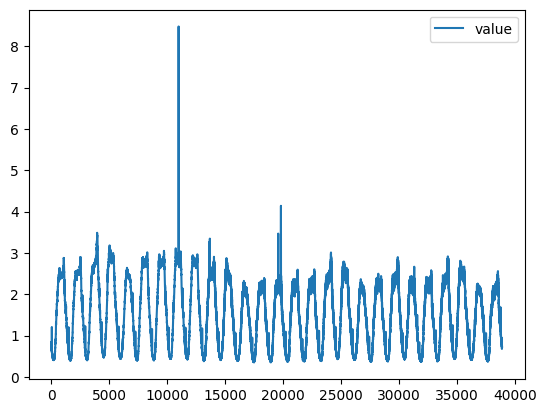

In [4]:
data.plot()

In [5]:
from torch import FloatTensor as FloatTensor

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [7]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [8]:
seed = 42

In [9]:
device = torch.device("cuda:0")

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360 # 1440
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [11]:
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [12]:
val_num = 1752

In [13]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_879295/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [14]:
train.tail(11)

,value
36949,2.025744
36950,2.118456
36951,2.019648
36952,2.115168
36953,2.013440
36954,2.115336
36955,2.035048
36956,2.130384
36957,2.018920
36958,2.139080


In [15]:
y_train.size()

torch.Size([35881, 360])

In [16]:
y_train[-1,-10:]

tensor([2.1185, 2.0196, 2.1152, 2.0134, 2.1153, 2.0350, 2.1304, 2.0189, 2.1391,
        2.0061], device='cuda:0')

In [17]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [18]:
x_train.size()

torch.Size([35881, 720])

In [19]:
x_val.size()

torch.Size([673, 720])

In [20]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [22]:
import copy

In [23]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [24]:
output = outputs
label = labels

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

0.013714848

In [27]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

0.013714848

### validation set에 대해서 attribution 구하기

In [28]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [29]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [30]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [31]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

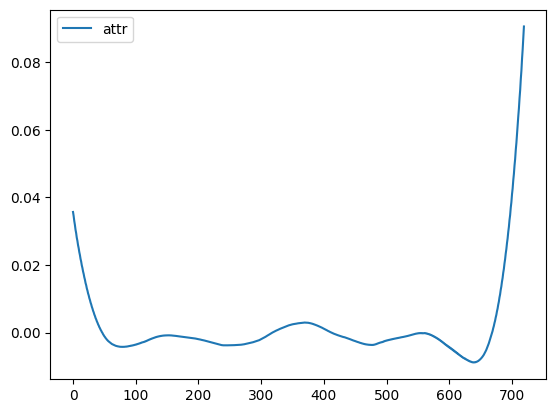

In [32]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

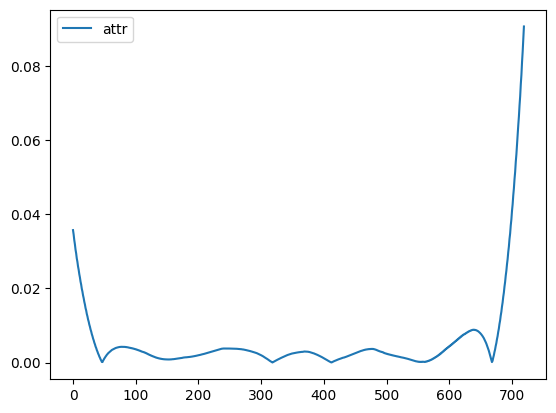

In [33]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [34]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
31,0.007113
32,0.006450
33,0.005978
34,0.005340
35,0.004893
...,...
673,0.003506
674,0.004460
675,0.005220
676,0.006270


In [35]:
outlier_max

attr    0.007336
dtype: float64

In [36]:
outlier_min

attr   -0.002152
dtype: float64

<AxesSubplot: >

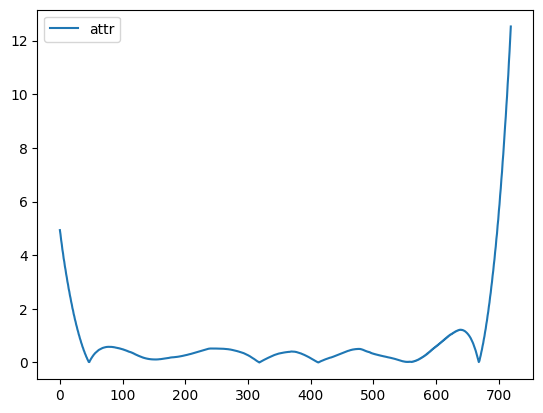

In [37]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [38]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.787615
std,1.598760
min,0.000000
25%,0.193312
50%,0.369613
75%,0.521208
max,12.524911


## 0과 1사이의 분포 확인하기

In [39]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
31,0.982234
32,0.890619
33,0.825325
34,0.737183
35,0.675334
...,...
673,0.483661
674,0.615560
675,0.720617
676,0.865728


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

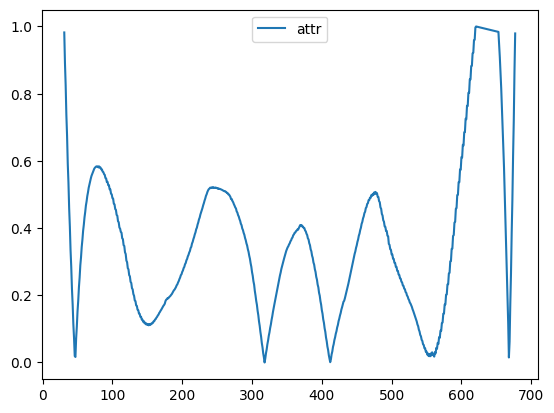

In [40]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

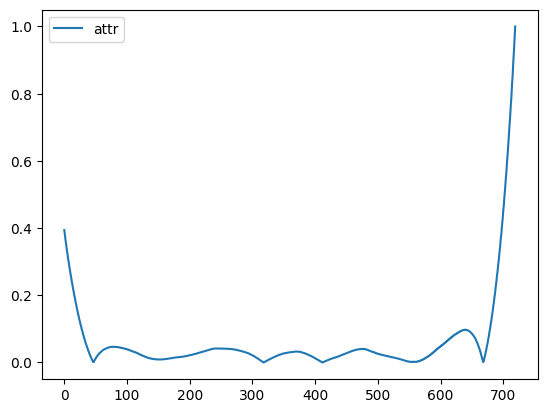

In [41]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [42]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [43]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


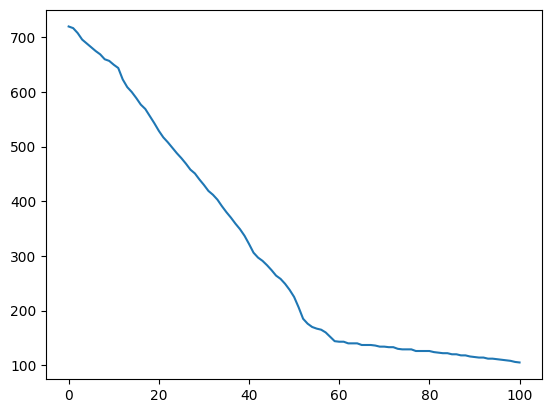

In [44]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:9.968728685515822
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
13번째 모델 Training 완료 마지막 Epoch loss:9.649205445137651
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
22번째 모델 Training 완료 마지막 Epoch loss:9.349503170752005
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


In [59]:
val_y # 다음 예측 타겟값

tensor([[2.1706, 2.0434, 2.2076,  ..., 1.3013, 1.4556, 1.4486],
        [2.0434, 2.2076, 2.0785,  ..., 1.4556, 1.4486, 1.4441],
        [2.2076, 2.0785, 2.2079,  ..., 1.4486, 1.4441, 1.4022],
        ...,
        [2.0503, 2.2138, 2.0268,  ..., 1.2879, 1.3275, 1.2760],
        [2.2138, 2.0268, 2.2316,  ..., 1.3275, 1.2760, 1.2880],
        [2.0268, 2.2316, 2.0247,  ..., 1.2760, 1.2880, 1.2628]],
       device='cuda:0')

In [60]:
val_x # 예측 하는 값

tensor([[0.4134, 0.4080, 0.4224,  ..., 2.0693, 2.1589, 2.0465],
        [0.4080, 0.4224, 0.4193,  ..., 2.1589, 2.0465, 2.1706],
        [0.4224, 0.4193, 0.4240,  ..., 2.0465, 2.1706, 2.0434],
        ...,
        [0.3967, 0.4235, 0.3933,  ..., 2.0624, 2.0713, 2.2258],
        [0.4235, 0.3933, 0.4152,  ..., 2.0713, 2.2258, 2.0503],
        [0.3933, 0.4152, 0.3915,  ..., 2.2258, 2.0503, 2.2138]],
       device='cuda:0')

In [61]:
result/68

0.0014531808521817712

In [62]:
val_x.size()

torch.Size([33, 720])

         out
52  0.065657


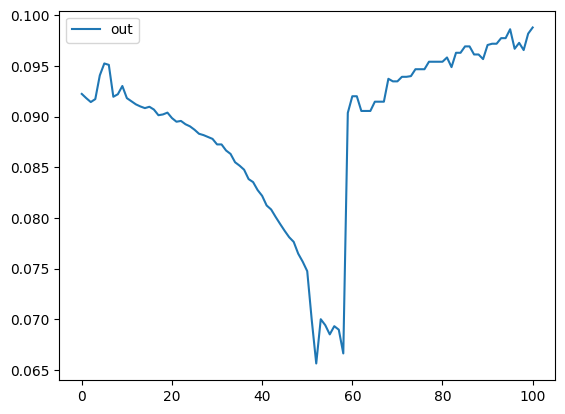

In [63]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [67]:
out_df 

,out
0,14.137815
1,14.082040
2,14.031108
3,14.077577
4,14.233167
...,...
96,12.381703
97,12.415942
98,12.363506
99,12.468921


         out
58  0.191992


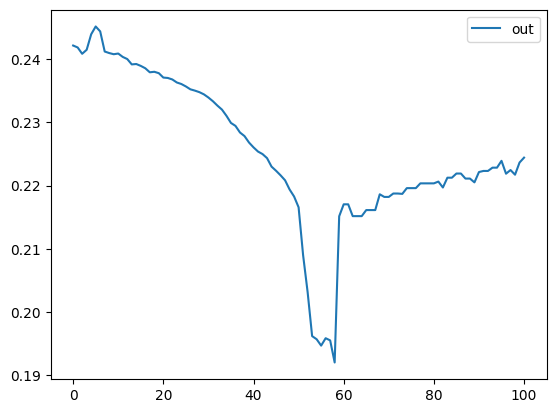

In [64]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [65]:
out_df 

,out
0,0.242187
1,0.241880
2,0.240878
3,0.241512
4,0.243968
...,...
96,0.221889
97,0.222467
98,0.221730
99,0.223656


          out
58  10.667089


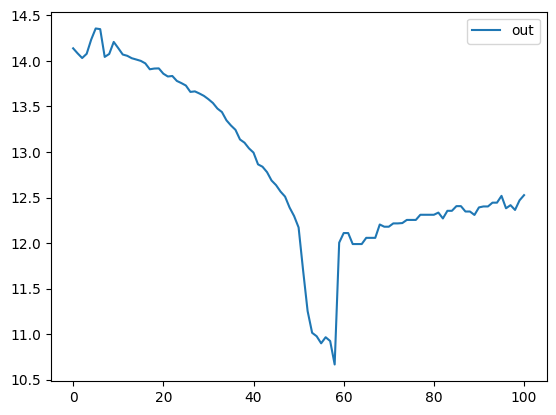

In [66]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [68]:
out_df 

,out
0,14.137815
1,14.082040
2,14.031108
3,14.077577
4,14.233167
...,...
96,12.381703
97,12.415942
98,12.363506
99,12.468921


         out
52  0.256237


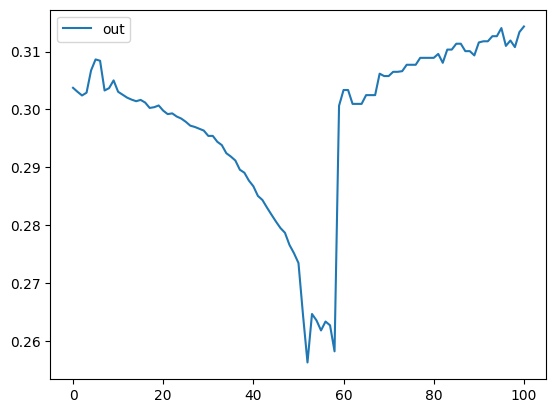

In [69]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [70]:
out_df 

,out
0,0.303742
1,0.303051
2,0.302418
3,0.302901
4,0.306741
...,...
96,0.310990
97,0.311929
98,0.310784
99,0.313382


In [71]:
attr_df.describe()

,attr
count,720.000000
mean,0.062884
std,0.127646
min,0.000000
25%,0.015434
50%,0.029510
75%,0.041614
max,1.000000
